In [22]:
#importando bibliotecas
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from pycaret.classification import *
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [182]:
#importando os dados
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [24]:
print('Quantidade de linhas:', data.shape[0])
print('Quantidade de colunas:', data.shape[1])

Quantidade de linhas: 7043
Quantidade de colunas: 21


In [25]:
data.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


- tenure = Number of months the customer has stayed with the company
- PhoneService = Whether the customer has a phone service or not (Yes, No)
- MultipleLines = Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService = Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity = Whether the customer has online security or not (Yes, No, No internet service)

In [26]:
#informações sobre as variáveis
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [183]:
#por algum motivo desconhecido a variável TotalCharges veio como tipo object
#nos passos abaixo vamos transformar ela em float

#retirando ' ' antes e depois dos valores
data['TotalCharges'] = data['TotalCharges'].map(lambda i: i.strip())
#substituindo valores faltantes por zero
data['TotalCharges'] = data['TotalCharges'].map(lambda i: 0 if i=='' else i)
#transformando os valores em números float
data['TotalCharges'] = data['TotalCharges'].map(lambda i:float(i))

In [28]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [29]:
data[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


Insights:
- Sem valores faltantes
- a maioria das variáveis estão no formato object
- o desvio padrão da variável TotalCharges está quase igual a média, isso pode ser um indicativo de outliers

In [11]:
#separando variável alvo
y = data['Churn']

#dataframe com as variáveis independentes
X = data.drop(columns='Churn', axis=1)

# Funções auxiliares

In [178]:
#criei essa função para avaliar a normalidade de algumas colunas
def teste_normal(coluna):
    from scipy.stats import normaltest
    print('A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.')
    print('A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.')
    print('')
    print('significância = 0.05')
    print('')
    print('Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.')
    print('Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.')
    print('')
    print('')
    stat_test, p_valor = normaltest(coluna)
    if p_valor < 0.05:
        print('p_valor = {}, H0 refutada, NÃO É NORMAL'.format(p_valor))
    else:
        print('p_valor = {}, H1 refutada, É NORMAL'.format(p_valor))
        
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Teste de hipóteses para variáveis categóricas 
# Nesse teste verificamos se a diferença do valor observado e do valor esperado é estatísticamente significativa

def teste_qui_quadrado(val1, val2):
    significancia = 0.1
    import pandas as pd
    from scipy.stats import chi2_contingency
    print('Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)')
    print('Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)')
    print('significância = {}'.format(significancia))
    print('')
    tabela = pd.crosstab(val1, val2)
    val =  chi2_contingency(tabela)
    p_valor = val[1]
    
    if p_valor > significancia:
        print('p_valor é {:.4f}, NÃO tem relação'.format(p_valor))
    else:
        print('p_valor é {:.4f}, TEM relação'.format(p_valor))
        
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Teste de hipóteses para variáveis contínuas
# Nesse teste verificamos se as distribuições de duas amostras independentes são iguais ou não.
# Esse teste é não paramétrico, então não precisamos que as amostras sejam normais.

# Premissa: 
# 1) As observações em cada amostra são independentes e distribuídas de forma idêntica (iid).

def teste_nao_parametrico(amostra1, amostra2):
    significancia = 0.1
    from scipy.stats import mannwhitneyu
    
    print('H0: a distribuição das duas amostras são iguais')
    print('H1: a distribuição das duas amostras NÃO são iguais')

    stat, p_valor = mannwhitneyu(amostra1, amostra2)
    if p_valor > significancia:
        print('P_valor é {}, provavalmente NÃO tem relação'.format(p_valor))
    else:
        print('P_valor é {}, provavalmente TEM relação'.format(p_valor))

# 1) -gender-
Representa o gênero do cliente

### Hipótese 1: O gênero tem relação com a taxa de Churn? 

In [32]:
#proporção de homens e mulheres 
data['gender'].value_counts(normalize=True)

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

In [46]:
tabela_gender = pd.crosstab(data['gender'], data['Churn'], normalize='index')
tabela_gender

Churn,No,Yes
gender,,
Female,0.730791,0.269209
Male,0.738397,0.261603


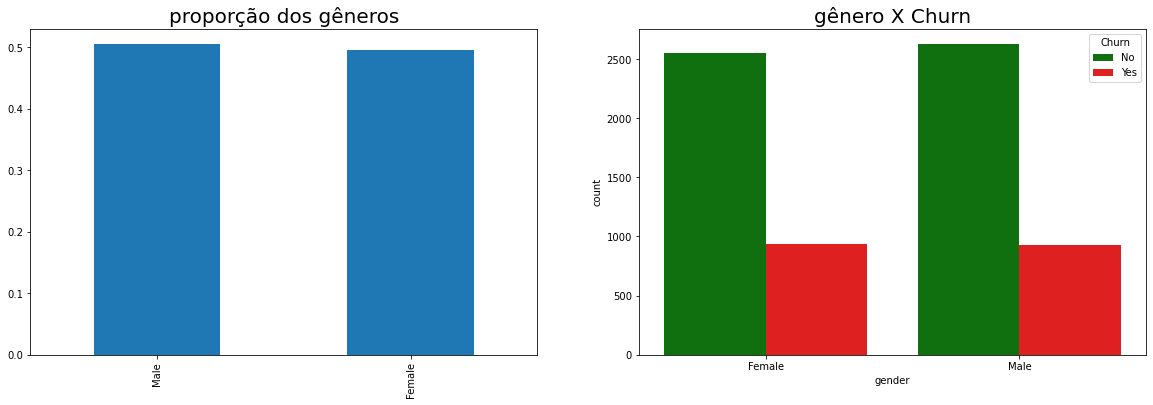

In [50]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
data['gender'].value_counts(normalize=True).plot(kind='bar')
plt.title('proporção dos gêneros', fontdict={'fontsize':20})
plt.subplot(1,2,2)
sns.countplot(data=data, x='gender', hue='Churn', palette=['green','red'])
plt.title('gênero X Churn', fontdict={'fontsize':20})
plt.show()

In [51]:
teste_qui_quadrado(data['gender'], data['Churn'])

Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)
Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)
significância = 0.1

p_valor é 0.4866, NÃO tem relação


Insights:
- Hipótese 1 refutada, o gênero NÃO TEM relação com a taxa de Churn

# 2) -SeniorCitizen-
Quer dizer se o cliente é idoso ou não

### Hipótese 2: Ser idoso tem relação com a taxa de Churn? 

In [52]:
#proporção de homens e mulheres 
data['SeniorCitizen'].value_counts(normalize=True)

0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64

In [53]:
tabela_SeniorCitizen = pd.crosstab(data['SeniorCitizen'], data['Churn'], normalize='index')
tabela_SeniorCitizen

Churn,No,Yes
SeniorCitizen,,
0,0.763938,0.236062
1,0.583187,0.416813


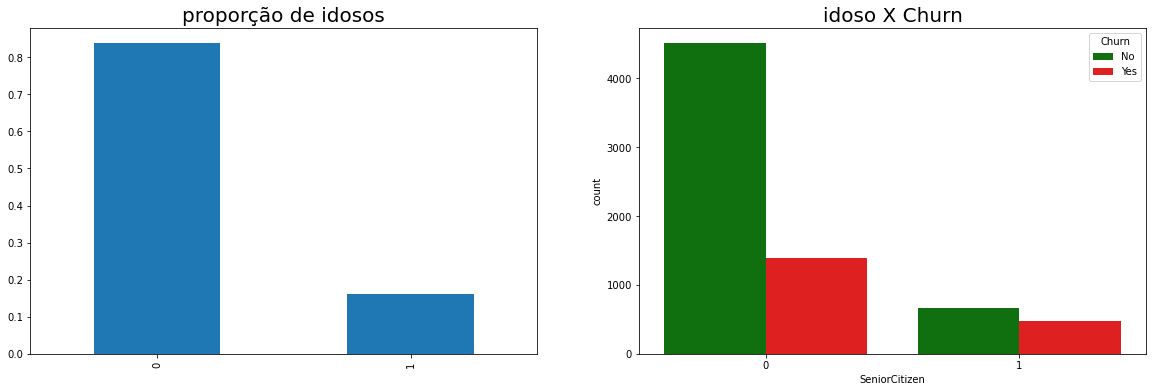

In [54]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
data['SeniorCitizen'].value_counts(normalize=True).plot(kind='bar')
plt.title('proporção de idosos', fontdict={'fontsize':20})
plt.subplot(1,2,2)
sns.countplot(data=data, x='SeniorCitizen', hue='Churn', palette=['green','red'])
plt.title('idoso X Churn', fontdict={'fontsize':20})
plt.show()

In [59]:
teste_qui_quadrado(data['SeniorCitizen'], data['Churn'])

Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)
Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)
significância = 0.1

p_valor é 0.0000, TEM relação


Insight:
- Hipótese 2 não refutada, ser idoso TEM relação com a taxa de Churn

# 3) -Partner-
Representa se o cliente tem ou não um parceiro(a)

### Hipótese 3: Ter um parceiro tem relação com a taxa de Churn? 

In [55]:
data['Partner'].value_counts(normalize=True)

No     0.516967
Yes    0.483033
Name: Partner, dtype: float64

In [63]:
tabela_Partner = pd.crosstab(data['Partner'], data['Churn'], normalize='index')
tabela_Partner

Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


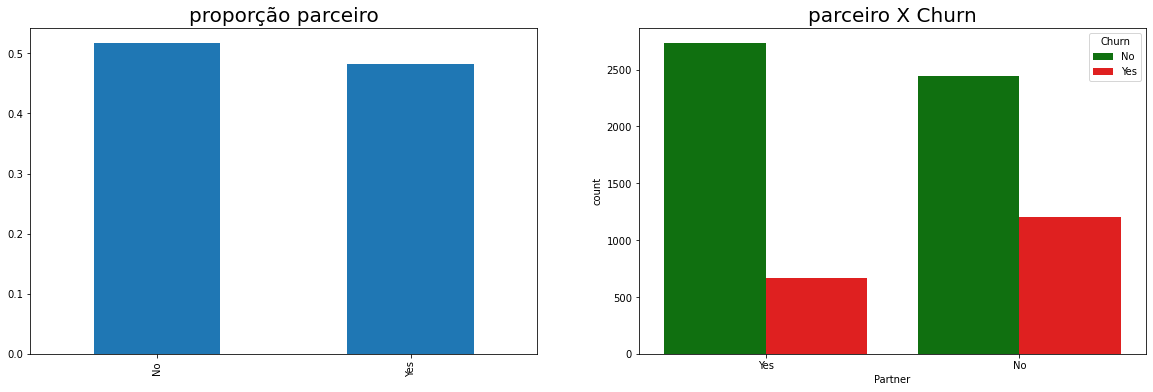

In [61]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
data['Partner'].value_counts(normalize=True).plot(kind='bar')
plt.title('proporção parceiro', fontdict={'fontsize':20})
plt.subplot(1,2,2)
sns.countplot(data=data, x='Partner', hue='Churn', palette=['green','red'])
plt.title('parceiro X Churn', fontdict={'fontsize':20})
plt.show()

In [60]:
teste_qui_quadrado(data['Partner'], data['Churn'])

Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)
Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)
significância = 0.1

p_valor é 0.0000, TEM relação


Insight:
- Na tabelinha acima podemos observar que pessoas que tem um parceiro(a) tem uma tendência menor a realizar Churn
- Hipótese 3 não refutada, ter um parceiro(a) TEM relação com a taxa de Churn

# 4) -Dependents-
Representa se o cliente tem ou não dependentes

### Hipótese 4: Temos uma taxa de churn maior em pessoas com dependentes? 

In [62]:
data['Dependents'].value_counts(normalize=True)

No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64

In [64]:
tabela_Dependents = pd.crosstab(data['Partner'], data['Churn'], normalize='index')
tabela_Dependents

Churn,No,Yes
Partner,,
No,0.670420,0.329580
Yes,0.803351,0.196649


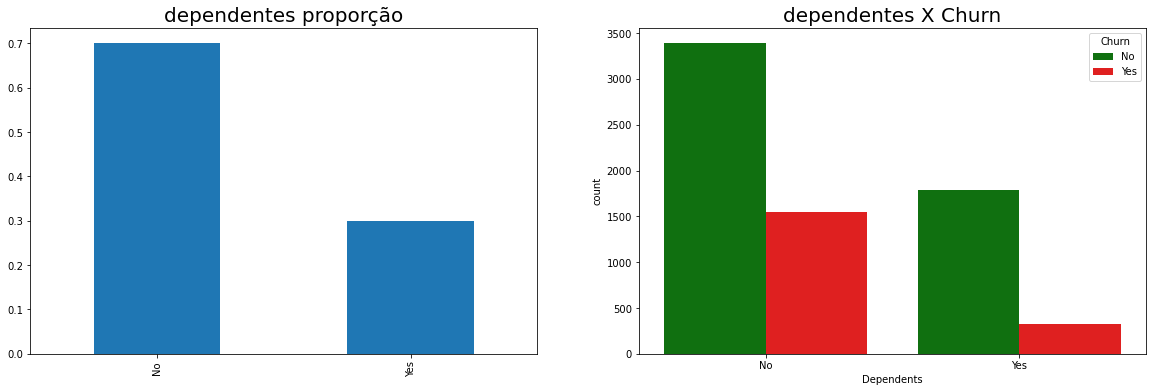

In [65]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
data['Dependents'].value_counts(normalize=True).plot(kind='bar')
plt.title('dependentes proporção', fontdict={'fontsize':20})
plt.subplot(1,2,2)
sns.countplot(data=data, x='Dependents', hue='Churn', palette=['green','red'])
plt.title('dependentes X Churn', fontdict={'fontsize':20})
plt.show()

In [66]:
teste_qui_quadrado(data['Dependents'], data['Churn'])

Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)
Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)
significância = 0.1

p_valor é 0.0000, TEM relação


Insights:
- Hipótese 4 não refutada, ter dependentes TEM relação com a taxa de Churn

# 5) -tenure-
Representa a quantidade de meses que o cliente permaneceu na empresa

### Hipótese 5: Temos uma diferença significativa estatísticamente para a distribuição de meses de permanência (tenure) dos clientes que realizaram churn ou não? 

In [70]:
data['tenure'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [189]:
print('')
print('Média dos meses que o cliente permaneceu na empresa:')
print('')
tenure_yes_churn_mean = data.query('Churn == "Yes" ')['tenure'].mean()
tenure_yes_churn_std = data.query('Churn == "Yes" ')['tenure'].std()
print('Yes churn => (Média = {:.2f} meses) - (Desvio Padrão = {:.2f} meses)'.format(tenure_yes_churn_mean, tenure_yes_churn_std))

tenure_no_churn_mean = data.query('Churn == "No" ')['tenure'].mean()
tenure_no_churn_std = data.query('Churn == "No" ')['tenure'].std()

print('No churn => (Média = {:.2f} meses) - (Desvio Padrão = {:.2f} meses)'.format(tenure_no_churn_mean, tenure_no_churn_std))


Média dos meses que o cliente permaneceu na empresa:

Yes churn => (Média = 17.98 meses) - (Desvio Padrão = 19.53 meses)
No churn => (Média = 37.57 meses) - (Desvio Padrão = 24.11 meses)


assimetria no_churn -0.03171986704146695
assimetria yes_churn 1.1492802882380029


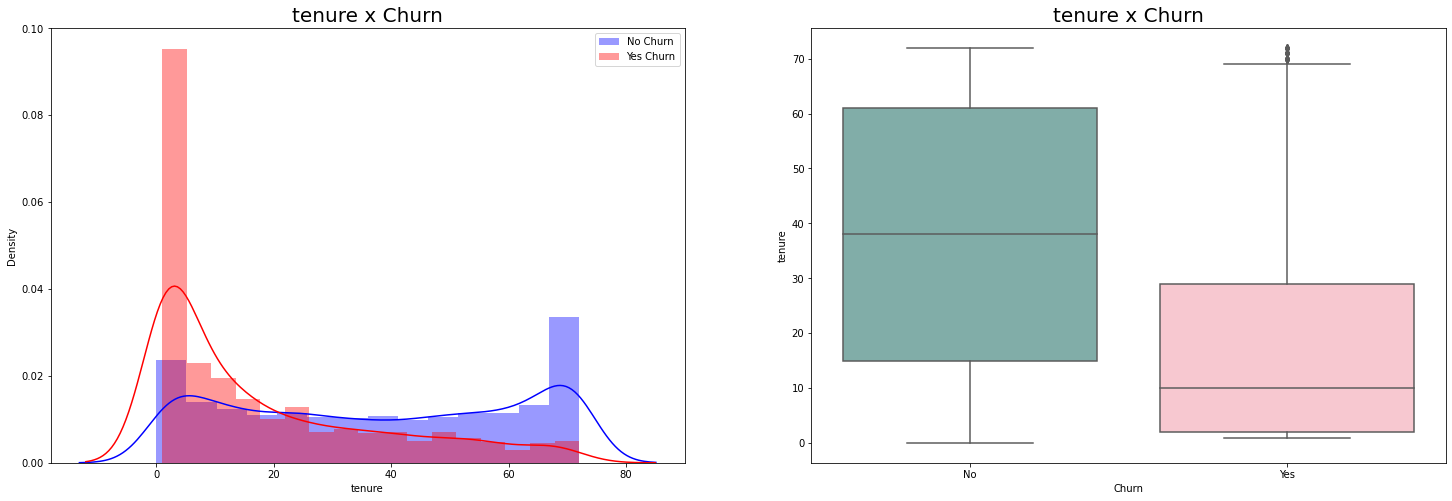

In [119]:
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
no_churn = data.query('Churn=="No" ')
sns.distplot(a=no_churn['tenure'], color='blue', label= 'No Churn')
print('assimetria no_churn', no_churn['tenure'].skew())

yes_churn = data.query('Churn=="Yes" ')
sns.distplot(a=yes_churn['tenure'], color='red', label= 'Yes Churn')
print('assimetria yes_churn', yes_churn['tenure'].skew())

plt.title('tenure x Churn',fontdict={'fontsize':20})
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(x='Churn', y='tenure', data=data, palette=['#7AB4AD', 'Pink'])
plt.title('tenure x Churn',fontdict={'fontsize':20})

plt.show()

In [179]:
teste_normal(data['tenure'])

A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.
A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.

significância = 0.05

Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.
Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.


p_valor = 0.0, H0 refutada, NÃO É NORMAL


- Como nossos dados não tem uma distribuição normal usaremos testes não paramétricos, ou seja, não adimitem normalidade como premissa

In [180]:
teste_nao_parametrico(yes_churn['tenure'], no_churn['tenure'])

H0: a distribuição das duas amostras são iguais
H1: a distribuição das duas amostras NÃO são iguais
P_valor é 1.209817758975933e-208, provavalmente TEM relação


Insights:
- Hipótese 5 não refutada, há uma diferença estatísticamente significativa entre as amostras de tenure com churn e sem churn
- Pessoas que estão há mais tempo como clientes tem uma taxa de churn menor

# PhoneService

### Hipótese 6: Ter ou não serviço de telefone tem relação com a taxa de churn?

In [172]:
data['PhoneService'].value_counts()

Yes    6361
No      682
Name: PhoneService, dtype: int64

In [173]:
tabela_Dependents = pd.crosstab(data['PhoneService'], data['Churn'], normalize='index')
tabela_Dependents

Churn,0,1
PhoneService,,
No,0.750733,0.249267
Yes,0.732904,0.267096


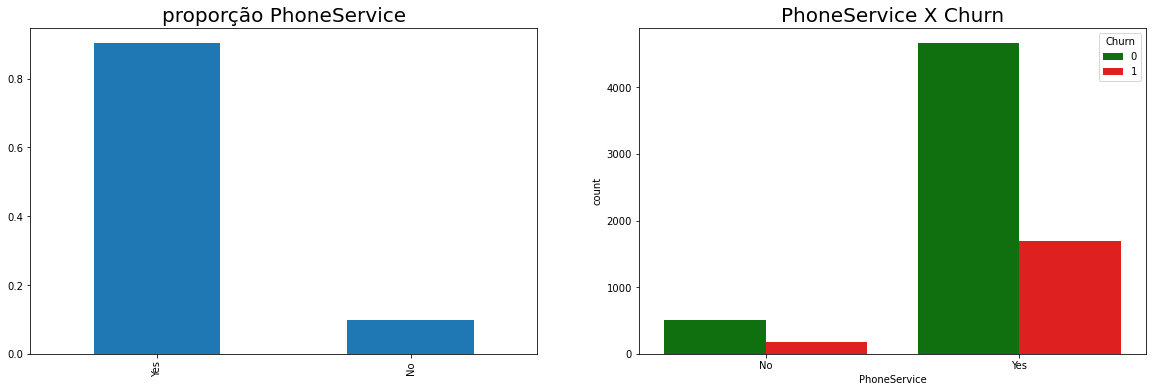

In [175]:
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
data['PhoneService'].value_counts(normalize=True).plot(kind='bar')
plt.title('proporção PhoneService', fontdict={'fontsize':20})
plt.subplot(1,2,2)
sns.countplot(data=data, x='PhoneService', hue='Churn', palette=['green','red'])
plt.title('PhoneService X Churn', fontdict={'fontsize':20})
plt.show()

In [176]:
teste_qui_quadrado(data['PhoneService'], data['Churn'])

Hipótese H0: a diferença entre o valor observado e o valor esperado NÃO É estatísticamente diferente de zero (p_valor < significância)
Hipótese H1: a diferença entre o valor observado e o valor esperado É estatísticamente diferente de zero (p_valor > significância)
significância = 0.1

p_valor é 0.3388, NÃO tem relação


Insight:
- Hipótese 6 refutada, Não há relação entra a taxa de churn e serviço telefônico

# TotalCharges

### Hipótese 7: Temos uma diferença significativa estatísticamente para a distribuição de cobranças totais dos clientes que realizaram churn ou não? 

In [191]:
data['TotalCharges'].describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64

Insights:
- Desvio padrão muito alto, pode indicar de outliers

In [194]:
print('')
print('Média das despesas totais do cliente:')
print('')
totalcharges_yes_churn_mean = data.query('Churn == "Yes" ')['TotalCharges'].mean()
totalcharges_yes_churn_std = data.query('Churn == "Yes" ')['TotalCharges'].std()
print('Yes churn => (Média = {:.2f} reais) - (Desvio Padrão = {:.2f} reais)'.format(totalcharges_yes_churn_mean, totalcharges_yes_churn_std))

totalcharges_no_churn_mean = data.query('Churn == "No" ')['TotalCharges'].mean()
totalcharges_no_churn_std = data.query('Churn == "No" ')['TotalCharges'].std()

print('No churn => (Média = {:.2f} reais) - (Desvio Padrão = {:.2f} reais)'.format(totalcharges_no_churn_mean, totalcharges_no_churn_std))


Média das despesas totais do cliente:

Yes churn => (Média = 1531.80 reais) - (Desvio Padrão = 1890.82 reais)
No churn => (Média = 2549.91 reais) - (Desvio Padrão = 2329.95 reais)



Assimetria no_churn 0.808
Curtose no_churn -0.550

Assimetria yes_churn 1.511
Curtose yes_churn 1.462



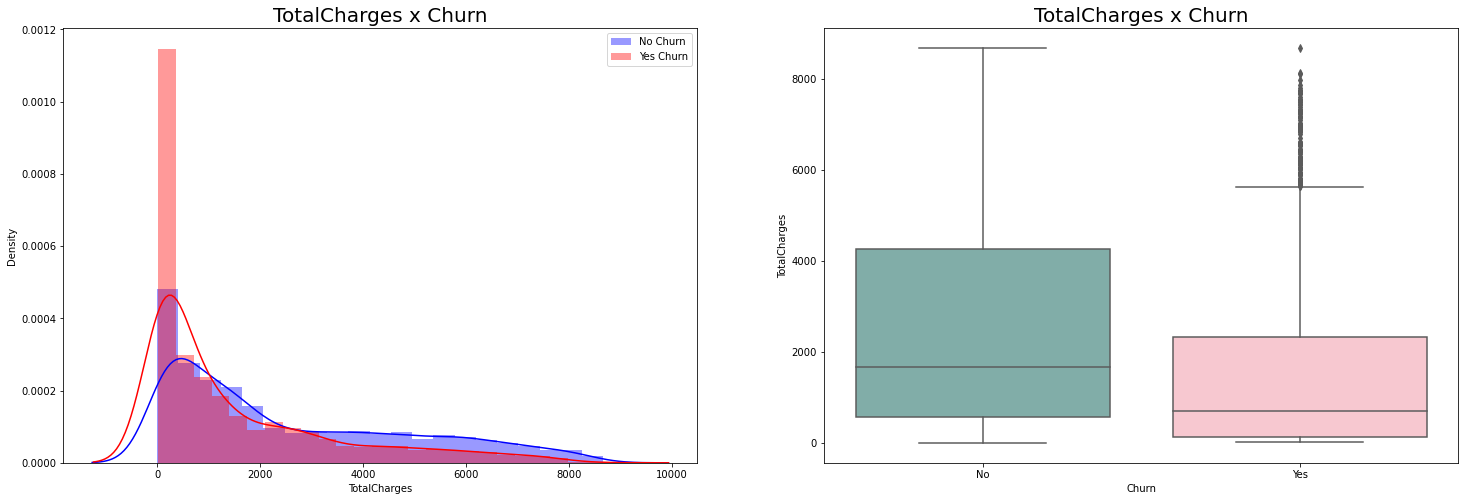

In [211]:
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
no_churn = data.query('Churn=="No" ')
sns.distplot(a=no_churn['TotalCharges'], color='blue', label= 'No Churn')

print('')
print('Assimetria no_churn {:.3f}'.format(no_churn['TotalCharges'].skew()))
print('Curtose no_churn {:.3f}'.format(no_churn['TotalCharges'].kurt()))
print('')

yes_churn = data.query('Churn=="Yes" ')
sns.distplot(a=yes_churn['TotalCharges'], color='red', label= 'Yes Churn')
print('Assimetria yes_churn {:.3f}'.format(yes_churn['TotalCharges'].skew()))
print('Curtose yes_churn {:.3f}'.format(yes_churn['TotalCharges'].kurt()))
print('')

plt.title('TotalCharges x Churn',fontdict={'fontsize':20})
plt.legend()

plt.subplot(1,2,2)
sns.boxplot(x='Churn', y='TotalCharges', data=data, palette=['#7AB4AD', 'Pink'])
plt.title('TotalCharges x Churn',fontdict={'fontsize':20})

plt.show()

In [212]:
teste_normal(data['TotalCharges'])

A hipótese H0 assume que a amostra É proveniente de uma distribuição normal.
A hipósete H1 assume que a a mostra NÃO é proveniente de uma distribuição normal.

significância = 0.05

Se P_VALOR < SINIFICÂNCIA, H0 é refutada, não é normal.
Se P_VALOR > SINIFICÂNCIA, H1 é refutada, é normal.


p_valor = 2.6049140547884828e-176, H0 refutada, NÃO É NORMAL


- Como nossos dados não tem uma distribuição normal usaremos testes não paramétricos, ou seja, não adimitem normalidade como premissa

In [213]:
teste_nao_parametrico(yes_churn['TotalCharges'], no_churn['TotalCharges'])

H0: a distribuição das duas amostras são iguais
H1: a distribuição das duas amostras NÃO são iguais
P_valor é 2.842516933103657e-83, provavalmente TEM relação


Insights:
- Hipótese 5 não refutada, há uma diferença significativa estatísticamente para a distribuição de cobranças totais dos clientes
- As duas amostras possuiem assimetria positiva


# MonthlyCharges

# Correlação

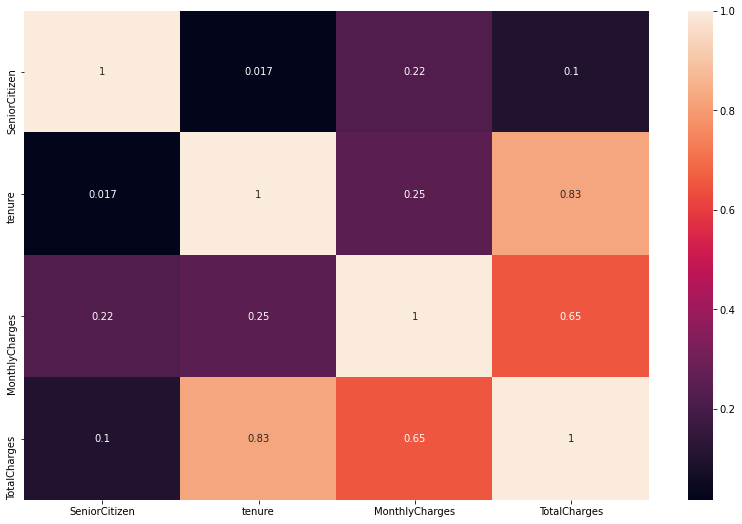

In [210]:
plt.figure(figsize =(14,9))
cor = data.corr()
sns.heatmap(cor, annot = True)
plt.show()

# Preprocessamento

In [156]:
#importando os dados
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

data['Churn'] = data['Churn'].map({'Yes':1, 'No':0})
#separando vetor alvo
y = data['Churn']

#dataframe sem o alvo
X = data.drop(columns='Churn', axis=1)


#binarizando a feature 'gender'
X['gender'] = X['gender'].map({'Female':1, 'Male':0})

#binarizando a feature 'Partner'
X['Partner'] = X['Partner'].map({'Yes':1, 'No':0})

#binarizando a feature 'Dependents'
X['Dependents'] = X['Dependents'].map({'Yes':1, 'No':0})

#binarizando a feature 'PaperlessBilling'
X['PaperlessBilling'] = X['PaperlessBilling'].map({'Yes':1, 'No':0})

#binarizando a feature 'PhoneService'
X['PhoneService'] = X['PhoneService'].map({'Yes':1, 'No':0})

#criando dummies nas features com mais de duas classes
X = pd.get_dummies(X, dtype='int64', columns=['MultipleLines', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                               'StreamingTV', 'StreamingMovies', 'Contract',
                              'PaymentMethod', 'InternetService' ])

#por algum motivo desconhecido a variável TotalCharges veio como tipo object
#nos passos abaixo vamos transformar ela em float

#retirando ' ' antes e depois dos valores
X['TotalCharges'] = X['TotalCharges'].map(lambda i: i.strip())
#substituindo valores faltantes por zero
X['TotalCharges'] = X['TotalCharges'].map(lambda i: 0 if i=='' else i)
#transformando os valores em números float
X['TotalCharges'] = X['TotalCharges'].map(lambda i:float(i))


#retirando a feature 'costumerID' pois não será útil em nosso modelo
X = X.drop(columns='customerID', axis=1)

In [157]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Modelagem

- Calculando nossa baseline

## -Baseline-

In [166]:
#baseline
from sklearn.dummy import DummyClassifier
mdl = DummyClassifier(strategy='stratified')
scores = cross_val_score(mdl, X, y, scoring='precision', cv=5).mean()
print(scores)

0.2622017703785555


## -DecisionTree-

In [169]:
mdl = DecisionTreeClassifier()
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(n,scores)
#0.7265362886315246 minmax accuracy

19 0.49068831073173974


## -RandomForest-

In [140]:
mdl = RandomForestClassifier(random_state=29)
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)
#0.7891549454803535 minmax accuracy

0.6390885840619251


## -LightGBM-

In [141]:
mdl = LGBMClassifier(random_state=29)
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)
#0.7941234111878186 minmax accuracy

0.6357827282451817


## -KNeighbors-

In [142]:
mdl = KNeighborsClassifier()
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)
#0.7603300011291052 minmax accuracy

0.5569768156275886


## -SVM-

In [143]:
mdl = SVC()
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)
#0.7971034421575586 minmax

0.6603272145886738


In [144]:
mdl = LogisticRegression()
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)
#0.8027834457061745 minmax

0.6538589540491253


In [145]:
mdl = XGBClassifier(random_state=29, verbosity=0)
scores = cross_val_score(mdl, X, y, scoring='precision').mean()
print(scores)

0.6072979328510673


# Pycaret

In [149]:

#importando os dados
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
#separando vetor alvo
y = data['Churn']
#dataframe sem o alvo
X = data[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'TotalCharges', 'MonthlyCharges', 'Churn']]

#binarizando a feature 'gender'
X['gender'] = X['gender'].map({'Female':1, 'Male':0})

#binarizando a feature 'Partner'
X['Partner'] = X['Partner'].map({'Yes':1, 'No':0})

#binarizando a feature 'Dependents'
X['Dependents'] = X['Dependents'].map({'Yes':1, 'No':0})

#binarizando a feature 'PhoneService'
X['PhoneService'] = X['PhoneService'].map({'Yes':1, 'No':0})

#retirando ' ' antes e depois dos valores
X['TotalCharges'] = X['TotalCharges'].map(lambda i: i.strip())
#substituindo valores faltantes por zero
X['TotalCharges'] = X['TotalCharges'].map(lambda i: 0 if i=='' else i)
#transformando os valores em números float
X['TotalCharges'] = X['TotalCharges'].map(lambda i:float(i))

#substituindo valores faltantes por zero
X['MonthlyCharges'] = X['MonthlyCharges'].map(lambda i: 0 if i=='' else i)
#transformando os valores em números float
X['MonthlyCharges'] = X['MonthlyCharges'].map(lambda i:float(i))

In [152]:
s = setup(X, target = 'Churn', numeric_features = ['MonthlyCharges', 'TotalCharges', 'tenure'],
          remove_outliers=True, fold_strategy = 'stratifiedkfold', fold_shuffle=True, remove_multicollinearity=True)

,Description,Value
0,session_id,3500
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 9)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


# Vamos comparar os modelos

In [153]:
best = compare_models(fold = 10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7941,0.8216,0.6951,0.7826,0.7834,0.4250,0.4337,0.1730
ada,Ada Boost Classifier,0.7922,0.8207,0.6882,0.7800,0.7799,0.4140,0.4248,0.0500
lr,Logistic Regression,0.7920,0.8119,0.6901,0.7796,0.7805,0.4163,0.4256,7.6870
ridge,Ridge Classifier,0.7894,0.0000,0.6788,0.7754,0.7749,0.3983,0.4111,0.0310
catboost,CatBoost Classifier,0.7894,0.8177,0.6814,0.7759,0.7759,0.4020,0.4135,1.8550
lda,Linear Discriminant Analysis,0.7852,0.8082,0.6900,0.7736,0.7761,0.4084,0.4140,0.0210
lightgbm,Light Gradient Boosting Machine,0.7850,0.8096,0.6853,0.7723,0.7744,0.4019,0.4090,0.3120
xgboost,Extreme Gradient Boosting,0.7753,0.7962,0.6782,0.7634,0.7662,0.3828,0.3881,0.5510
rf,Random Forest Classifier,0.7642,0.7799,0.6619,0.7501,0.7537,0.3486,0.3540,0.1160
knn,K Neighbors Classifier,0.7628,0.7449,0.6612,0.7491,0.7526,0.3463,0.3515,0.0320


In [304]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,pycaret.internal.tunable.TunableMLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


# Selecionando o melhor algoritmo

In [305]:
catboost = create_model('catboost', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8073,0.8080,0.7044,0.7960,0.7958,0.4504,0.4611
1,0.8093,0.8162,0.7107,0.7986,0.7991,0.4607,0.4697
2,0.7992,0.8320,0.6933,0.7867,0.7866,0.4278,0.4391
3,0.7627,0.7879,0.6685,0.7516,0.7556,0.3554,0.3578
4,0.7931,0.8362,0.7015,0.7825,0.7852,0.4307,0.4353
5,0.7708,0.7980,0.6617,0.7548,0.7582,0.3539,0.3612
6,0.7890,0.7868,0.6642,0.7737,0.7697,0.3767,0.3965
7,0.7992,0.8277,0.6859,0.7863,0.7840,0.4182,0.4337
8,0.7992,0.8181,0.6908,0.7865,0.7858,0.4246,0.4372
9,0.7972,0.8210,0.6969,0.7851,0.7864,0.4298,0.4381


In [307]:
evaluate_model(catboost)

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


# Otimizando o modelo

In [308]:
tuned_cat = tune_model(catboost, fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7972,0.8104,0.6800,0.7834,0.7812,0.4068,0.4228
1,0.8012,0.8120,0.6927,0.7886,0.7882,0.4283,0.4405
2,0.8073,0.8296,0.6988,0.7961,0.7936,0.4448,0.4596
3,0.7809,0.7954,0.6735,0.7661,0.7685,0.3808,0.3892
4,0.7931,0.8445,0.6966,0.7814,0.7837,0.4246,0.4308
5,0.7748,0.7830,0.6595,0.7578,0.7598,0.3549,0.3654
6,0.7931,0.7945,0.6743,0.7788,0.7761,0.3956,0.4126
7,0.7992,0.8282,0.6834,0.7863,0.7831,0.4150,0.4320
8,0.8174,0.8271,0.7057,0.8089,0.8024,0.4667,0.4868
9,0.8114,0.8293,0.7213,0.8019,0.8031,0.4767,0.4832


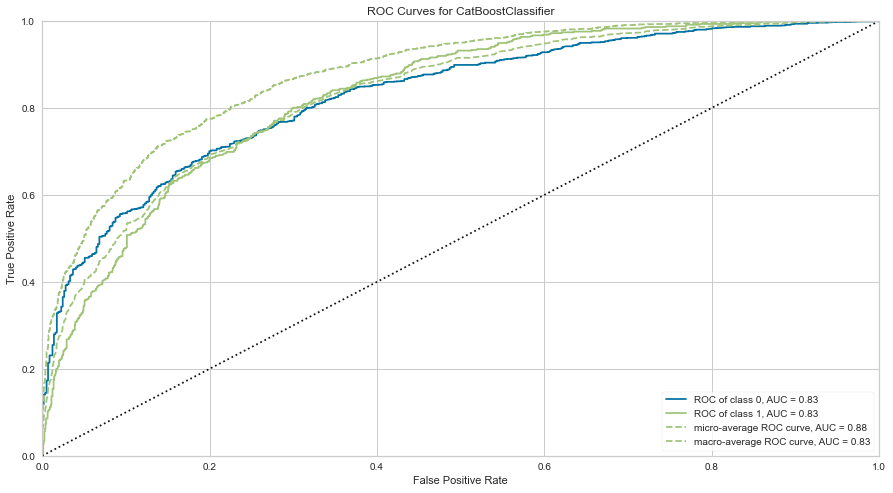

In [312]:
fig=plt.figure(figsize=(15,8))
plot_model(tuned_cat)

# Visualizando o erro do modelo

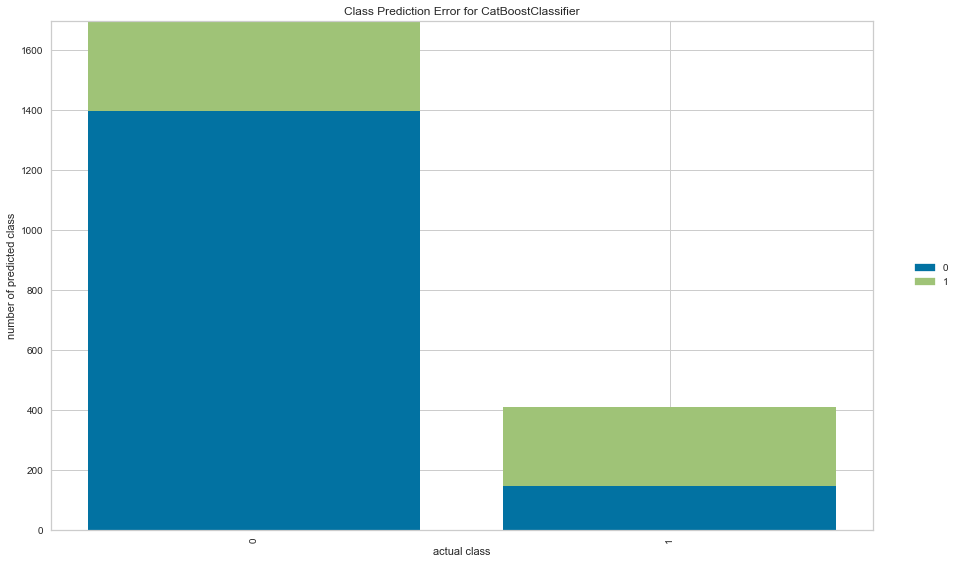

In [316]:
fig=plt.figure(figsize=(15,8))
plot_model(tuned_cat, plot = 'error')

# Visualizando as features importantes

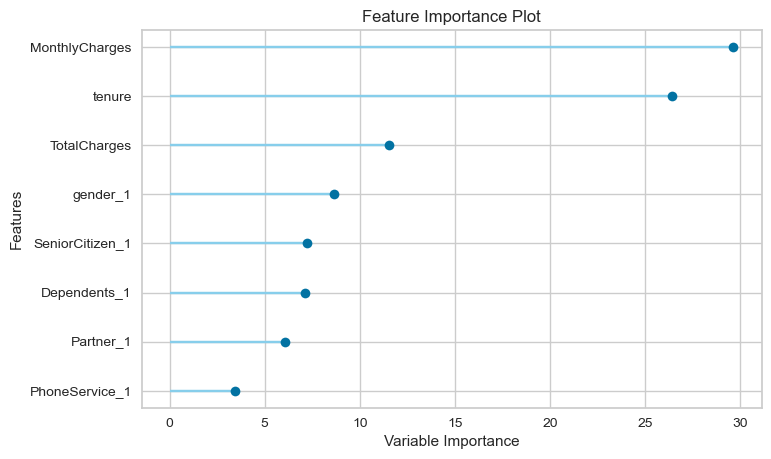

In [317]:
plot_model(tuned_cat, plot='feature')

# Finaliza o modelo

In [318]:
final_cat = finalize_model(tuned_cat)

# Persistindo o modelo

In [319]:
save_model(final_cat,'modelo-final')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['MonthlyCharges',
                                                           'TotalCharges',
                                                           'tenure'],
                                       target='Churn', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,...
                 ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Churn')),
                 ('fix_perfect', Remove_100(t